# EfficientNet-B0 CNN Cross Validation

In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../src/')

import numpy as np
import pandas as pd
import torch
import timm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from dataloading import SpectrogramDataset, repeat_channels
from metrics import compute_metrics
from training import train
from evaluation import plot_spectrogram_slices, plot_spectrograms, plot_spectrogram_with_predictions, evaluate_model
from torch.utils.data._utils.collate import default_collate
from sklearn.model_selection import train_test_split, KFold

from torchsummary import summary
import matplotlib.pyplot as plt

plt.rcdefaults()

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=False),
    transforms.Lambda(repeat_channels),  # repeat grayscale image to 3 channels to match model input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

In [3]:
DATA_PATH = "../data/dataset_h5"
FILE_EXT = "h5"
LABEL_PATH = "../data/MHD_labels"
LABEL_FILE_EXT = "csv"
WINDOW_SIZE = 100  # number of .512ms time steps per window
OVERLAP_FACTOR = 0.6  # overlap between consecutive windows



indices = np.arange(94)
# split the dataset into train/validation and test sets
train_val_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=42)
# split the dataset into train and validation sets
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.2, random_state=42)

print("Train indices:", list(train_indices))
print("Val indices:", list(val_indices))
print("Test indices:", list(test_indices))


Train indices: [86, 6, 43, 68, 27, 38, 7, 65, 29, 4, 87, 19, 53, 36, 51, 66, 59, 28, 37, 84, 77, 1, 16, 64, 30, 32, 62, 69, 17, 49, 79, 18, 24, 74, 57, 50, 56, 92, 11, 34, 73, 45, 54, 47, 89, 71, 82, 41, 76, 60, 48, 88, 2, 3, 80, 35, 46, 70, 90, 42, 20, 85, 9, 81, 21, 33, 75]
Val indices: [23, 83, 58, 5, 78, 52, 15, 31, 12, 63, 8, 93, 13, 14, 91, 61, 25]
Test indices: [40, 22, 55, 72, 0, 26, 39, 67, 10, 44]


## Perform 5-fold cross validation on the train/validation set

Training on fold 1/5...


Processing dataset:   0%|          | 0/67 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 4308
Shot numbers: [64376, 64378, 64389, 64394, 64401, 64646, 64647, 64648, 64650, 64659, 64662, 64664, 64666, 64668, 64673, 64675, 64677, 64680, 64682, 64684, 64686, 64770, 64774, 64778, 64820, 64834, 70355, 70357, 70380, 70381, 70382, 70383, 70388, 70389, 70390, 70391, 70392, 70393, 71182, 71186, 71188, 71189, 71190, 71192, 71222, 71223, 71225, 71226, 71255, 71256, 71259, 71260, 71265, 71266, 71292, 71300, 72196, 72198, 72920, 72925, 72926, 72927, 72928, 72929, 72930, 72961, 72963]


Processing dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 1151
Shot numbers: [64374, 64392, 64649, 64658, 64670, 64678, 70356, 70359, 70387, 70394, 71193, 71194, 71224, 71264, 71303, 72919, 72959]
training on device 'cuda'


Epoch 0:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.958, f1: 0.892, kappa: 0.867, best threshold: 0.850
     Validation accuracy: 0.958, f1: 0.884, kappa: 0.859, best threshold: 0.900


Epoch 1:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.982, f1: 0.954, kappa: 0.943, best threshold: 0.910
     Validation accuracy: 0.961, f1: 0.897, kappa: 0.872, best threshold: 0.890


Epoch 2:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.994, f1: 0.985, kappa: 0.981, best threshold: 0.830
     Validation accuracy: 0.965, f1: 0.913, kappa: 0.891, best threshold: 0.560


Epoch 3:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.997, f1: 0.992, kappa: 0.990, best threshold: 0.830
     Validation accuracy: 0.964, f1: 0.907, kappa: 0.884, best threshold: 0.550


Epoch 4:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.998, f1: 0.995, kappa: 0.994, best threshold: 0.840
     Validation accuracy: 0.963, f1: 0.905, kappa: 0.882, best threshold: 0.340


Epoch 5:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 5 | Train accuracy: 0.998, f1: 0.995, kappa: 0.994, best threshold: 0.750
     Validation accuracy: 0.964, f1: 0.907, kappa: 0.884, best threshold: 0.400


Epoch 6:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 6 | Train accuracy: 0.998, f1: 0.995, kappa: 0.994, best threshold: 0.650
     Validation accuracy: 0.962, f1: 0.903, kappa: 0.879, best threshold: 0.260


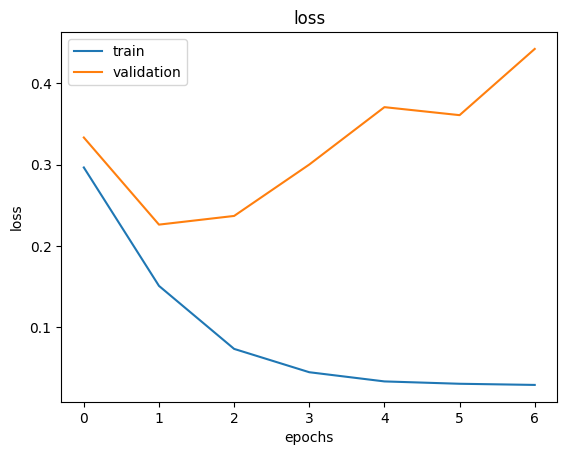

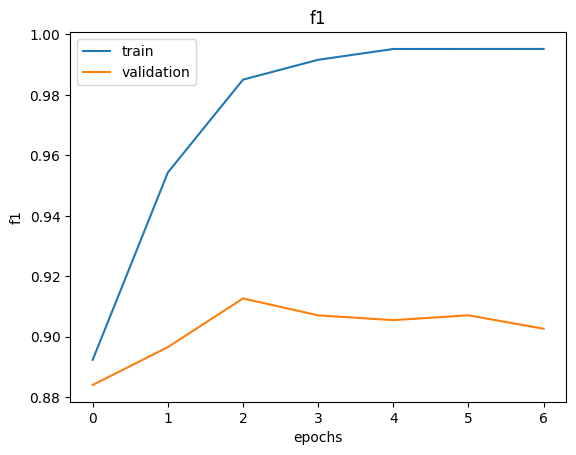

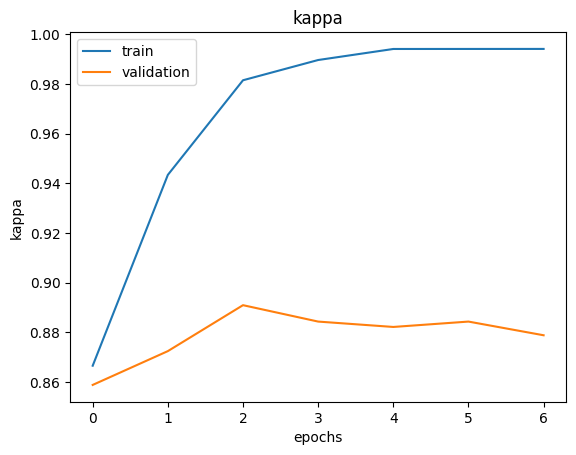

best threshold over validation set: 0.26
Training on fold 2/5...


Processing dataset:   0%|          | 0/67 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 4320
Shot numbers: [64374, 64376, 64378, 64389, 64392, 64401, 64646, 64647, 64649, 64658, 64659, 64662, 64664, 64668, 64670, 64673, 64675, 64677, 64678, 64680, 64682, 64684, 64686, 64770, 64778, 70355, 70356, 70359, 70380, 70381, 70382, 70387, 70388, 70390, 70393, 70394, 71182, 71188, 71189, 71190, 71192, 71193, 71194, 71222, 71223, 71224, 71225, 71226, 71255, 71256, 71259, 71264, 71265, 71266, 71300, 71303, 72196, 72198, 72919, 72920, 72925, 72927, 72928, 72929, 72930, 72959, 72961]


Processing dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 1139
Shot numbers: [64394, 64648, 64650, 64666, 64774, 64820, 64834, 70357, 70383, 70389, 70391, 70392, 71186, 71260, 71292, 72926, 72963]
training on device 'cuda'


Epoch 0:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.962, f1: 0.896, kappa: 0.872, best threshold: 0.910
     Validation accuracy: 0.953, f1: 0.884, kappa: 0.854, best threshold: 0.930


Epoch 1:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.986, f1: 0.964, kappa: 0.955, best threshold: 0.770
     Validation accuracy: 0.954, f1: 0.898, kappa: 0.869, best threshold: 0.620


Epoch 2:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.996, f1: 0.990, kappa: 0.988, best threshold: 0.870
     Validation accuracy: 0.956, f1: 0.895, kappa: 0.867, best threshold: 0.940


Epoch 3:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.998, f1: 0.996, kappa: 0.995, best threshold: 0.760
     Validation accuracy: 0.957, f1: 0.903, kappa: 0.875, best threshold: 0.720


Epoch 4:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.999, f1: 0.996, kappa: 0.995, best threshold: 0.730
     Validation accuracy: 0.957, f1: 0.903, kappa: 0.876, best threshold: 0.710


Epoch 5:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 5 | Train accuracy: 0.999, f1: 0.997, kappa: 0.996, best threshold: 0.730
     Validation accuracy: 0.957, f1: 0.903, kappa: 0.876, best threshold: 0.640


Epoch 6:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 6 | Train accuracy: 0.999, f1: 0.997, kappa: 0.996, best threshold: 0.810
     Validation accuracy: 0.956, f1: 0.901, kappa: 0.873, best threshold: 0.830


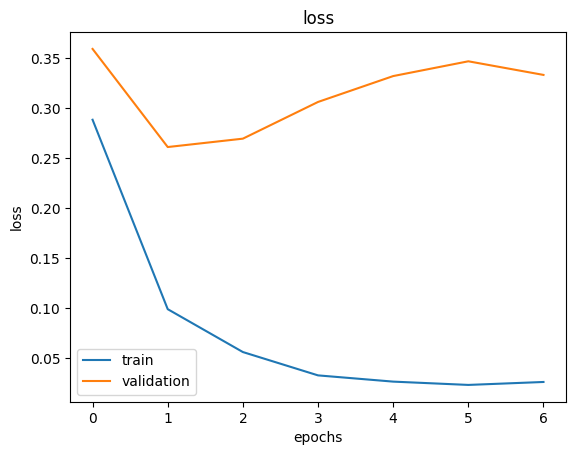

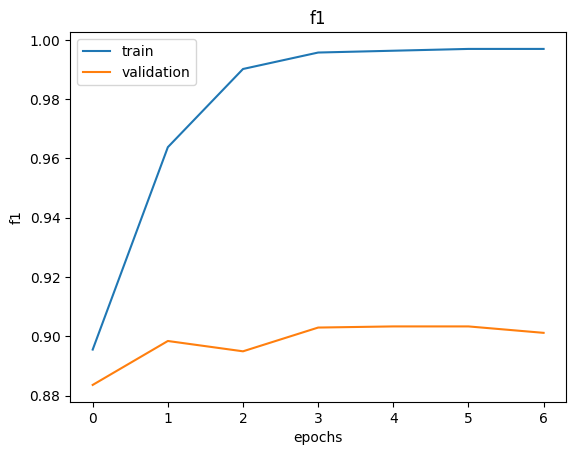

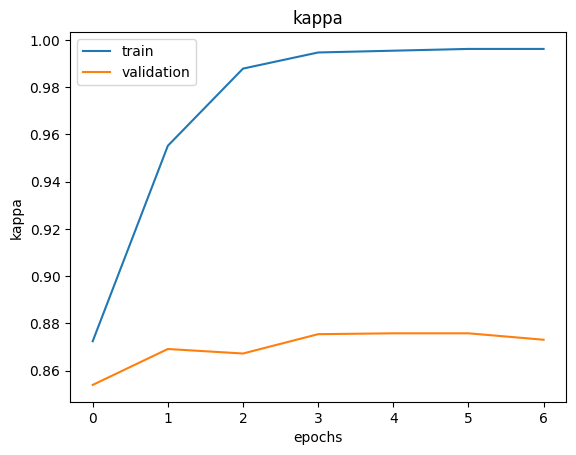

best threshold over validation set: 0.8300000000000001
Training on fold 3/5...


Processing dataset:   0%|          | 0/67 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 4336
Shot numbers: [64374, 64376, 64378, 64392, 64394, 64648, 64649, 64650, 64658, 64662, 64664, 64666, 64670, 64675, 64677, 64678, 64680, 64682, 64686, 64770, 64774, 64778, 64820, 64834, 70355, 70356, 70357, 70359, 70381, 70383, 70387, 70388, 70389, 70390, 70391, 70392, 70393, 70394, 71182, 71186, 71188, 71189, 71190, 71193, 71194, 71223, 71224, 71225, 71226, 71255, 71259, 71260, 71264, 71292, 71303, 72196, 72198, 72919, 72920, 72926, 72927, 72928, 72929, 72930, 72959, 72961, 72963]


Processing dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 1123
Shot numbers: [64389, 64401, 64646, 64647, 64659, 64668, 64673, 64684, 70380, 70382, 71192, 71222, 71256, 71265, 71266, 71300, 72925]
training on device 'cuda'


Epoch 0:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.955, f1: 0.866, kappa: 0.839, best threshold: 0.890
     Validation accuracy: 0.963, f1: 0.929, kappa: 0.903, best threshold: 0.800


Epoch 1:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.984, f1: 0.956, kappa: 0.946, best threshold: 0.790
     Validation accuracy: 0.966, f1: 0.935, kappa: 0.912, best threshold: 0.590


Epoch 2:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.994, f1: 0.984, kappa: 0.981, best threshold: 0.860
     Validation accuracy: 0.969, f1: 0.942, kappa: 0.920, best threshold: 0.500


Epoch 3:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.998, f1: 0.995, kappa: 0.994, best threshold: 0.810
     Validation accuracy: 0.969, f1: 0.942, kappa: 0.921, best threshold: 0.350


Epoch 4:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.999, f1: 0.997, kappa: 0.996, best threshold: 0.790
     Validation accuracy: 0.971, f1: 0.944, kappa: 0.924, best threshold: 0.580


Epoch 5:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 5 | Train accuracy: 0.999, f1: 0.997, kappa: 0.997, best threshold: 0.820
     Validation accuracy: 0.969, f1: 0.941, kappa: 0.920, best threshold: 0.350


Epoch 6:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 6 | Train accuracy: 0.999, f1: 0.998, kappa: 0.998, best threshold: 0.810
     Validation accuracy: 0.969, f1: 0.942, kappa: 0.921, best threshold: 0.190


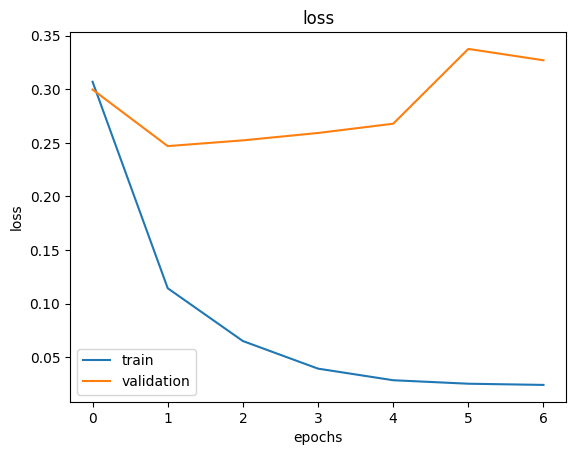

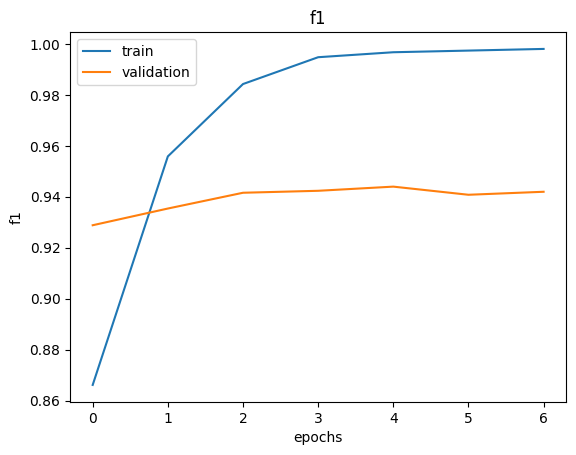

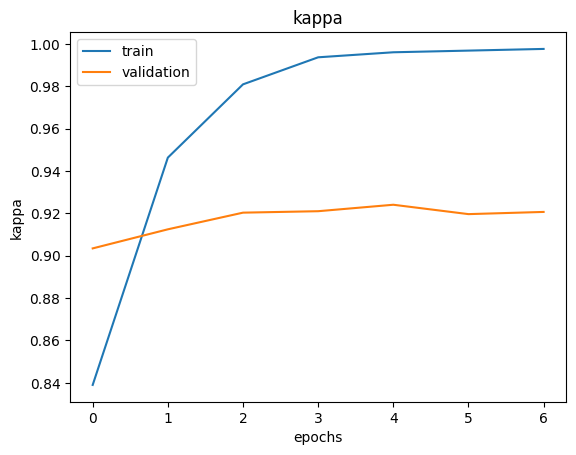

best threshold over validation set: 0.19
Training on fold 4/5...


Processing dataset:   0%|          | 0/67 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 4456
Shot numbers: [64374, 64376, 64378, 64389, 64392, 64394, 64401, 64646, 64647, 64648, 64649, 64650, 64658, 64659, 64662, 64666, 64668, 64670, 64673, 64675, 64677, 64678, 64680, 64684, 64774, 64778, 64820, 64834, 70356, 70357, 70359, 70380, 70381, 70382, 70383, 70387, 70389, 70391, 70392, 70394, 71186, 71189, 71190, 71192, 71193, 71194, 71222, 71224, 71226, 71256, 71259, 71260, 71264, 71265, 71266, 71292, 71300, 71303, 72196, 72198, 72919, 72920, 72925, 72926, 72928, 72959, 72963]


Processing dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 1003
Shot numbers: [64664, 64682, 64686, 64770, 70355, 70388, 70390, 70393, 71182, 71188, 71223, 71225, 71255, 72927, 72929, 72930, 72961]
training on device 'cuda'


Epoch 0:   0%|          | 0/70 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.959, f1: 0.896, kappa: 0.871, best threshold: 0.880
     Validation accuracy: 0.957, f1: 0.859, kappa: 0.834, best threshold: 0.880


Epoch 1:   0%|          | 0/70 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.987, f1: 0.967, kappa: 0.959, best threshold: 0.830
     Validation accuracy: 0.971, f1: 0.907, kappa: 0.890, best threshold: 0.790


Epoch 2:   0%|          | 0/70 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.995, f1: 0.987, kappa: 0.984, best threshold: 0.840
     Validation accuracy: 0.971, f1: 0.912, kappa: 0.895, best threshold: 0.590


Epoch 3:   0%|          | 0/70 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.998, f1: 0.996, kappa: 0.995, best threshold: 0.840
     Validation accuracy: 0.969, f1: 0.906, kappa: 0.887, best threshold: 0.710


Epoch 4:   0%|          | 0/70 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.999, f1: 0.997, kappa: 0.997, best threshold: 0.840
     Validation accuracy: 0.971, f1: 0.911, kappa: 0.894, best threshold: 0.650


Epoch 5:   0%|          | 0/70 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?batch/s]

Epoch 5 | Train accuracy: 0.999, f1: 0.998, kappa: 0.997, best threshold: 0.800
     Validation accuracy: 0.970, f1: 0.909, kappa: 0.891, best threshold: 0.550


Epoch 6:   0%|          | 0/70 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/70 [00:00<?, ?batch/s]

Epoch 6 | Train accuracy: 0.999, f1: 0.998, kappa: 0.997, best threshold: 0.780
     Validation accuracy: 0.970, f1: 0.910, kappa: 0.892, best threshold: 0.440


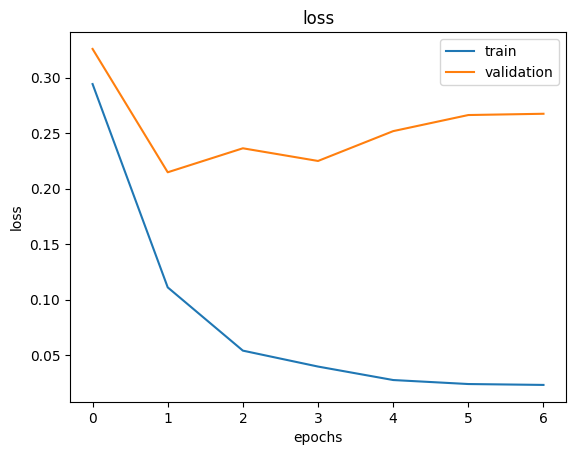

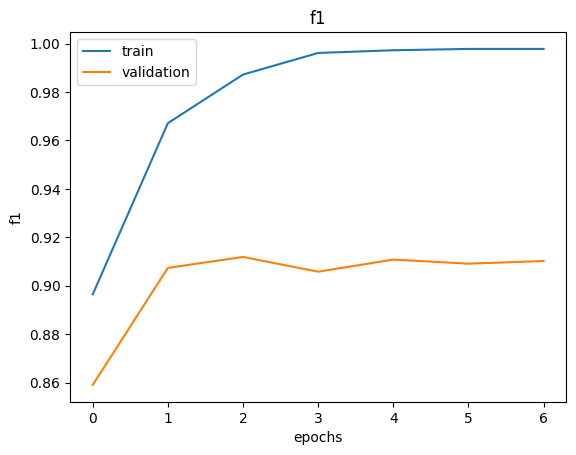

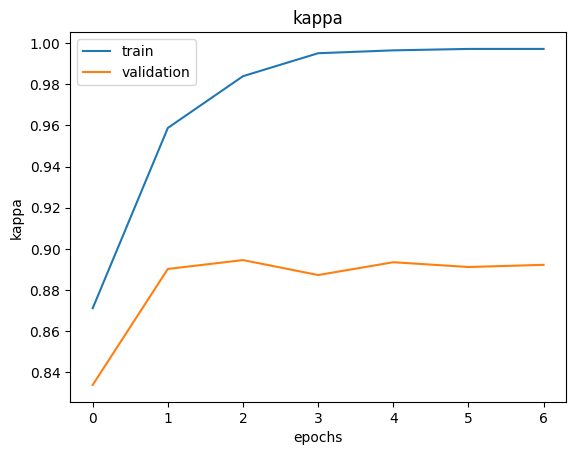

best threshold over validation set: 0.44
Training on fold 5/5...


Processing dataset:   0%|          | 0/68 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 4416
Shot numbers: [64374, 64389, 64392, 64394, 64401, 64646, 64647, 64648, 64649, 64650, 64658, 64659, 64664, 64666, 64668, 64670, 64673, 64678, 64682, 64684, 64686, 64770, 64774, 64820, 64834, 70355, 70356, 70357, 70359, 70380, 70382, 70383, 70387, 70388, 70389, 70390, 70391, 70392, 70393, 70394, 71182, 71186, 71188, 71192, 71193, 71194, 71222, 71223, 71224, 71225, 71255, 71256, 71260, 71264, 71265, 71266, 71292, 71300, 71303, 72919, 72925, 72926, 72927, 72929, 72930, 72959, 72961, 72963]


Processing dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 1043
Shot numbers: [64376, 64378, 64662, 64675, 64677, 64680, 64778, 70381, 71189, 71190, 71226, 71259, 72196, 72198, 72920, 72928]
training on device 'cuda'


Epoch 0:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.971, f1: 0.929, kappa: 0.911, best threshold: 0.840
     Validation accuracy: 0.916, f1: 0.705, kappa: 0.656, best threshold: 0.870


Epoch 1:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.989, f1: 0.974, kappa: 0.967, best threshold: 0.840
     Validation accuracy: 0.921, f1: 0.745, kappa: 0.700, best threshold: 0.770


Epoch 2:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.997, f1: 0.992, kappa: 0.990, best threshold: 0.850
     Validation accuracy: 0.916, f1: 0.733, kappa: 0.685, best threshold: 0.550


Epoch 3:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.999, f1: 0.998, kappa: 0.998, best threshold: 0.800
     Validation accuracy: 0.921, f1: 0.745, kappa: 0.700, best threshold: 0.650


Epoch 4:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.999, f1: 0.998, kappa: 0.998, best threshold: 0.750
     Validation accuracy: 0.919, f1: 0.744, kappa: 0.698, best threshold: 0.560


Epoch 5:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 5 | Train accuracy: 1.000, f1: 0.999, kappa: 0.999, best threshold: 0.740
     Validation accuracy: 0.921, f1: 0.744, kappa: 0.699, best threshold: 0.520


Epoch 6:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 6 | Train accuracy: 1.000, f1: 0.999, kappa: 0.999, best threshold: 0.740
     Validation accuracy: 0.921, f1: 0.748, kappa: 0.703, best threshold: 0.520


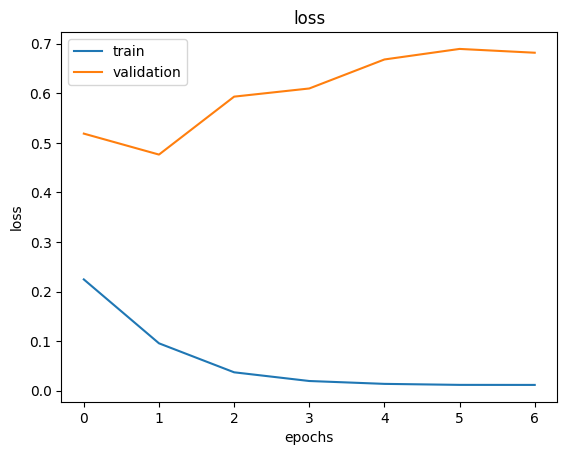

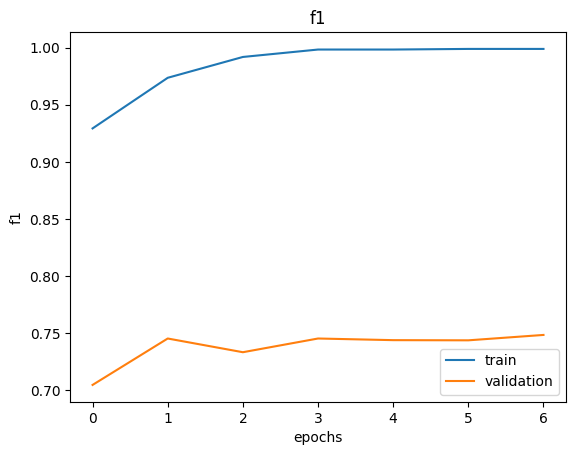

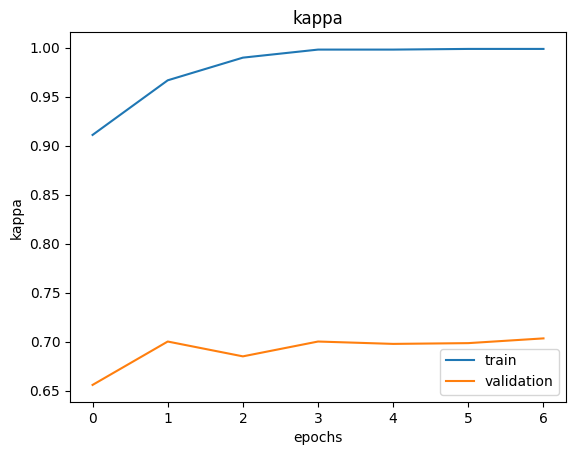

best threshold over validation set: 0.52
5-fold cross validation results:
Train F1: 0.997 ± 0.001
Val F1: 0.881 ± 0.068
Train Kappa: 0.997 ± 0.002
Val Kappa: 0.854 ± 0.077
Train Best Threshold: 0.758 ± 0.060
Val Best Threshold: 0.448 ± 0.225


In [4]:
# cross validate model using 5-fold cross validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Placeholder lists to store results for each fold
all_train_results = []
all_val_results = []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_indices)):
    print(f"Training on fold {fold+1}/{k}...")

    # Split the dataset into the current fold's train and validation sets
    train_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                                       file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                                       overlap=OVERLAP_FACTOR, transform=transform, shot_filter=train_idx)
    val_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                                     file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                                     overlap=OVERLAP_FACTOR, transform=transform, shot_filter=val_idx)

    # Create DataLoaders for the current fold
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=default_collate, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=default_collate, num_workers=0)
    
    # Create model
    # EfficientNet-B0 -- 4M params
    model = timm.create_model('efficientnet_b0', pretrained=True, drop_rate=0.2)
    
    # replace classifier layer for binary classification
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, 640),  
        nn.ReLU(),
        nn.Linear(640, 1)  # output one value
    )
    
    # check proportion of positive samples in train set
    j = 0
    for i in range(len(train_loader.dataset) - 1):
        j += train_loader.dataset[i]['label']
    pos_proportion = j / len(train_loader.dataset)
    
    num_epochs = 7

    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1/pos_proportion]).to(device))  # binary Cross Entropy Loss with Logits
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )

    # Train the model on the current fold
    train_f1, val_f1, train_kappa, val_kappa, train_thresh, val_thresh = train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, n_epochs=num_epochs)

    # Save the results for this fold
    all_train_results.append((train_f1, train_kappa, train_thresh))
    all_val_results.append((val_f1, val_kappa, val_thresh))
    
    del model, train_dataset, val_dataset, train_loader, val_loader, criterion, optimizer, scheduler
    if device == "cuda":
        torch.cuda.empty_cache()

print(f"{k}-fold cross validation results:")
print(f"Train F1: {np.mean([x[0] for x in all_train_results]):.3f} ± {np.std([x[0] for x in all_train_results]):.3f}")
print(f"Val F1: {np.mean([x[0] for x in all_val_results]):.3f} ± {np.std([x[0] for x in all_val_results]):.3f}")
print(f"Train Kappa: {np.mean([x[1] for x in all_train_results]):.3f} ± {np.std([x[1] for x in all_train_results]):.3f}")
print(f"Val Kappa: {np.mean([x[1] for x in all_val_results]):.3f} ± {np.std([x[1] for x in all_val_results]):.3f}")
print(f"Train Best Threshold: {np.mean([x[2] for x in all_train_results]):.3f} ± {np.std([x[2] for x in all_train_results]):.3f}")
print(f"Val Best Threshold: {np.mean([x[2] for x in all_val_results]):.3f} ± {np.std([x[2] for x in all_val_results]):.3f}")